In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from time import sleep
from sklearn.inspection import permutation_importance

In [2]:
# My target is shot_made_flag 

df = pd.read_csv("../Datasets/kobe.csv")
data_process = df.dropna().reset_index()

minutes = data_process["minutes_remaining"].values
secondes = data_process["seconds_remaining"].values
temps_restant = pd.Series((minutes*60 + secondes), name="temps_restant")

qualitative_vars = ["action_type", "combined_shot_type", "game_event_id", "game_id", "period", "playoffs", "season", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range", "team_name", "game_date", "matchup", "opponent"]
quantitative_vars = [col for col in data_process.columns if col not in qualitative_vars + ["shot_made_flag", "shot_id", 'team_id', "minutes_remaining", "seconds_remaining"]]  # garder le shot_id ?

data_process = data_process.drop(columns=["minutes_remaining","seconds_remaining"], axis=1)
quantitative_vars.append("temps_restant")
data = pd.concat([data_process, temps_restant], axis=1)
X = data[qualitative_vars + quantitative_vars].values
X_quantitative = data[quantitative_vars].values
X_categorical = data[qualitative_vars].values
y = data_process["shot_made_flag"].values

feature_names = quantitative_vars + qualitative_vars

In [3]:
X_preprocess = X_quantitative
for feature in qualitative_vars:
    label_encoder = LabelEncoder()
    X_cat_label = label_encoder.fit_transform(data[feature].values)
    X_preprocess = np.concatenate([X_preprocess, X_cat_label.reshape(25697,1)], axis=1)

In [11]:
def apprentissage(nom_modele, X,y):

    modele = {"knn": [KNeighborsClassifier, {'n_neighbors': range(1,101,10), 'weights': ['uniform', 'distance'], 'p': [1, 2]}],
              "decision_tree": [DecisionTreeClassifier, {"criterion": ["gini", "entropy", "log_loss"], "max_features": range(1, 10, 1), "max_depth": range(1, 10, 1)}],
              "random_forest": [RandomForestClassifier, {"n_estimators": range(1, 10, 5), "criterion": ["gini", "entropy"], "max_depth" : range(1,20,1)}],
              "gbayes": [GaussianNB, {}],
              "cbayes": [CategoricalNB, {'alpha': [0.1, 0.5, 1.0]}]
              }
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

    
    if nom_modele =='reg_lin':
        grid_search_cv = GridSearchCV(estimator=LogisticRegression(max_iter=5000, solver="liblinear"), param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']})
    else:
        grid_search_cv = GridSearchCV(estimator=modele[nom_modele][0](), param_grid=modele[nom_modele][1])
    
    grid_search_cv.fit(X, y)
    sleep(10)  
    print(f"Best score: {grid_search_cv.best_score_}")
    print(f"For parameters: {grid_search_cv.best_params_}")
    
    best_params = grid_search_cv.best_params_

    # Fit and test tree using best params    
    if nom_modele == 'reg_lin':
        model_optimized = LogisticRegression(**best_params, solver="liblinear", max_iter=5000)
    else:
        model_optimized = modele[nom_modele][0](**best_params)

    model_optimized.fit(X_train, y_train)
    importance(modele, nom_modele, model_optimized, best_params, X, y)

In [12]:
def importance(modele, nom_modele, model, best_params, X, y, seuil=0.02):

    modele_importance = {'reg_lin':0,
                         'knn':knn_importance(model, nom_modele, X, y),
                         'decision_tree':tree_importance(model, nom_modele),
                         'random_forest': tree_importance(model, nom_modele),
                         'gbayes':gaussian_importance(model, nom_modele),
                         'cbayes':cbayes_importance(model),
                        }
    print("======= Top Features")
    score_feature_names = [feature_names[i] for i, importance in enumerate(modele_importance[nom_modele])]
    important_feature_names = [feature_names[i] for i, importance in enumerate(modele_importance[nom_modele]) if importance > seuil]
    print(f"Les variables les plus importantes pour la prise de décisions sont {important_feature_names}")
    
    mask = modele_importance[nom_modele] > seuil
    sub_X = X[:,mask]

    X_train, X_test, y_train, y_test = train_test_split(sub_X, y,test_size=0.2, random_state=0)
    if nom_modele == 'reg_lin':
        model_optimized = LogisticRegression(**best_params, solver="liblinear", max_iter=5000)
    else:
        model_optimized = modele[nom_modele][0](**best_params)

    model_optimized.fit(X_train, y_train)
    predictions= model_optimized.predict(X_test)
    print(classification_report(y_test, predictions))

In [17]:
def cbayes_importance(model):
    feature_log_prob = model.feature_log_prob_

    # Afficher l'importance relative des caractéristiques
    print("Log Probabilités conditionnelles par caractéristique et par classe:")
    for i, log_prob in enumerate(feature_log_prob):
        print(f"Classe {i}:")
        for j, prob in enumerate(log_prob.T):
            print(f"  Caractéristique {j}: {prob}")

    return np.var(feature_log_prob, axis=0)

In [13]:
def tree_importance(model, nom):  
    if nom == "decision_tree" or nom == "random_forest":
        return model.feature_importances_
    else:
        return 0

In [14]:
def knn_importance(knn, nom, X, y):
    if nom == "knn":

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        feature_mask = np.zeros(X_train.shape[1], dtype=bool)
        best_score = 0.0

        # Itérer jusqu'à ce que toutes les caractéristiques soient examinées
        while not all(feature_mask):
            temp_best_score = best_score
            best_feature = None
            
            # Tester l'ajout de chaque caractéristique non sélectionnée
            for feature in range(X_train.shape[1]):
                if not feature_mask[feature]:
                    # Créer un nouveau masque pour l'essai actuel avec la caractéristique candidate incluse
                    trial_mask = feature_mask.copy()
                    trial_mask[feature] = True
                    
                    # Sélectionner les caractéristiques pour l'entraînement et le test
                    X_train_selected = X_train[:, trial_mask]
                    X_test_selected = X_test[:, trial_mask]

                    knn.fit(X_train_selected, y_train)
                    y_pred = knn.predict(X_test_selected)
                    score = accuracy_score(y_test, y_pred)
                    
                    # Mettre à jour le meilleur score et la meilleure caractéristique
                    if score > temp_best_score:
                        temp_best_score = score
                        best_feature = feature
            
            # Vérifier si une caractéristique améliorant le score a été trouvée
            if best_feature is not None and temp_best_score > best_score:
                best_score = temp_best_score
                feature_mask[best_feature] = True
                print(f"Caractéristique {best_feature} ajoutée avec un score de {best_score}")
            else:
                # Arrêter si l'ajout de nouvelles caractéristiques n'améliore pas le score
                break

        return feature_mask
    else:
        return 0

In [15]:
def gaussian_importance(gaussian_nb, nom):
    if nom == "gbayes":
        means = gaussian_nb.theta_
        variances = gaussian_nb.var_
        return np.abs(means[1] - means[0]) / np.sqrt(variances[0] + variances[1])
    else:
        return 0

In [24]:
apprentissage("gbayes", X_preprocess, y)

Best score: 0.6211233695483459
For parameters: {}
======= Top Features
Les variables les plus importantes pour la prise de décisions sont ['lat', 'loc_y', 'shot_distance', 'temps_restant', 'combined_shot_type', 'game_event_id', 'period', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'matchup']
              precision    recall  f1-score   support

         0.0       0.61      0.70      0.65      2866
         1.0       0.54      0.43      0.48      2274

    accuracy                           0.58      5140
   macro avg       0.57      0.57      0.57      5140
weighted avg       0.58      0.58      0.58      5140



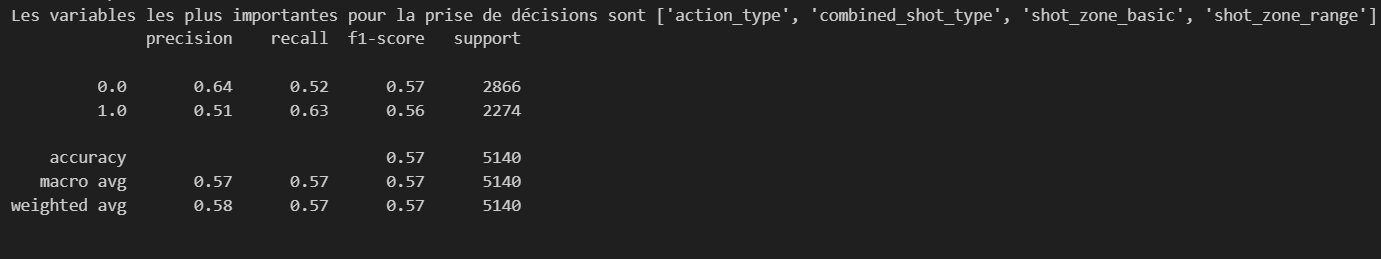

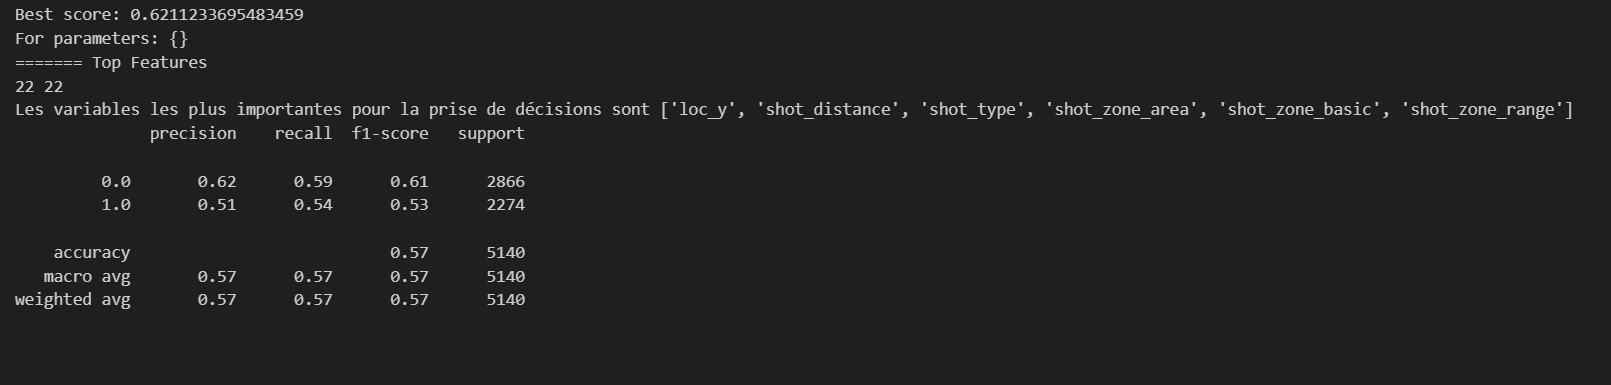